In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, explained_variance_score, mean_absolute_error, max_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

# Function to load dataset from file and apply basic data cleaning
def load_coin_data(data_file='../../data/crypto-markets.csv'):
    try:
        df = pd.read_csv(data_file)
    except FileNotFoundError:
        print("ERROR: data file not found")
        return None
    
    # Convert date column from string to datetime
    df['date'] = pd.to_datetime(df['date'])

    # Align all end dates to '2018-11-29'
    df = df[df['date'] != '2018-11-30']

    # Sort the dataset by 'slug' and 'date'
    df = df.sort_values(['slug', 'date'])

    # Add next closing price and next day return columns
    df['next_close'] = df.groupby('slug')['close'].shift(-1)
    df['next_return'] = (df['next_close'] - df['close']) / df['close']

    # Drop the last row of each coin as we don't have the next day's closing price
    df = df.dropna()

    # Reset the dataframe index
    df = df.reset_index(drop=True)

    return df

 

In [2]:
# Function to filter dataset to only contain coins with specific number of years of data
def filter_by_years(df, years=4):
    return df.groupby('slug').filter(lambda x: len(x) > (365 * years)).reset_index(drop=True)

# Function to split dataset by specific date
def split_train_test(df, date='2017-11-28'):
    train = df.loc[df['date'] < date].reset_index(drop=True)
    test = df.loc[df['date'] >= date].reset_index(drop=True)
    return train, test

# Load data
DATA_FILE = '../../data/crypto-markets.csv'
df = load_coin_data(DATA_FILE)

# Filter data with a slug named 'bitcoin'
btc_data = df[df['slug'] == 'bitcoin']

# Filter to coins with 4+ years of data
btc_data = filter_by_years(btc_data)

# Sort by date descending
sorted_btc_data = btc_data.sort_values('date', ascending=False)


sorted_btc_data['T-1'] = sorted_btc_data['close'].shift(-1)
sorted_btc_data['T-2'] = sorted_btc_data['close'].shift(-2)
sorted_btc_data['T-3'] = sorted_btc_data['close'].shift(-3)
sorted_btc_data['T-4'] = sorted_btc_data['close'].shift(-4)
sorted_btc_data['T-5'] = sorted_btc_data['close'].shift(-5)

sorted_btc_data['close_price_change%'] =(((sorted_btc_data['close']/sorted_btc_data['T-1'])- 1) * 100).map("{:.2f}%".format)

sorted_btc_data['MA_5'] = sorted_btc_data['close'].rolling(window=3, min_periods=1).mean()
sorted_btc_data['MA_5_change%'] = (
    (sorted_btc_data['MA_5'] / sorted_btc_data['close'].shift(-1) - 1) * 100)


In [3]:
# Drop rows with NaN values resulting from shifting
sorted_btc_data = sorted_btc_data.dropna()

# Split data into train and test datasets using the custom split function
train, test = split_train_test(sorted_btc_data)

# Define features (X) and target (y) for training and testing
X_train = train[['T-1', 'T-2', 'T-3', 'T-4', 'T-5', 'MA_5_change%']]
y_train = train['close']
X_test = test[['T-1', 'T-2', 'T-3', 'T-4', 'T-5', 'MA_5_change%']]
y_test = test['close']

# Standardize features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)  
X_test_scaled = scaler.transform(X_test)      


Best k: 1
Test RMSE: 2160.37
               Metric        Value
0  Explained Variance     0.524751
1           Max Error  9679.050000
2                RMSE  2160.372398
3                 MAE  1225.322541
4           R-Squared     0.492628


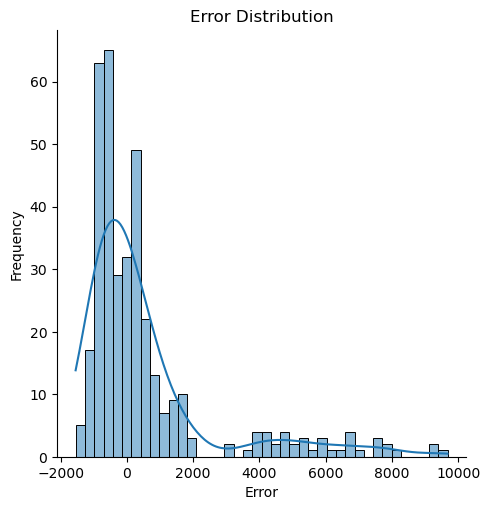

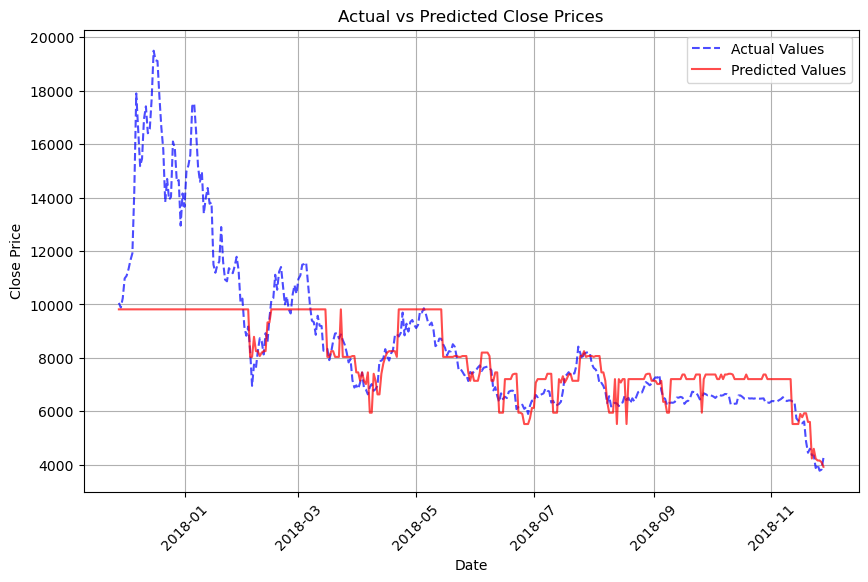

In [4]:
# Grid search with cross-validation on the training set
param_grid = {'n_neighbors': range(1, 21)}  # Test k from 1 to 20
knn = KNeighborsRegressor()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

# Best hyperparameters
best_k = grid_search.best_params_['n_neighbors']
print(f"Best k: {best_k}")

# Train final KNN model with the best `k`
best_knn = grid_search.best_estimator_


# Evaluate on the test set
predicted = best_knn.predict(X_test_scaled)
rmse = np.sqrt(mean_squared_error(y_test, predicted))
print(f"Test RMSE: {rmse:.2f}")

# Calculate additional metrics
explained_variance = explained_variance_score(y_test, predicted)
max_error_value = max_error(y_test, predicted)
mae = mean_absolute_error(y_test, predicted)
r_squared = r2_score(y_test, predicted)

# Create a DataFrame for metrics
metrics = {
    'Metric': ['Explained Variance', 'Max Error', 'RMSE', 'MAE', 'R-Squared'],
    'Value': [explained_variance, max_error_value, rmse, mae, r_squared]
}

metrics_df = pd.DataFrame(metrics)

# Display the metrics table
print(metrics_df)

# Graph 1: Error distribution plot
error = y_test - predicted
sns.displot(error, kde=True, bins=40)
plt.title('Error Distribution')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()

# Graph 2: Actual vs Predicted values
plt.figure(figsize=(10, 6))
plt.plot(test['date'], y_test.values, label='Actual Values', color='blue', linestyle='dashed', alpha=0.7)
plt.plot(test['date'], predicted, label='Predicted Values', color='red', alpha=0.7)
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.grid(True)
plt.show()


Observation and Analysis
- The error distribution of the model predictions on the testing data indicates that the model produces some significantly large errors on the positive side.
- Combined with observations from Graph 2, the model performs worst when the price reaches a peak exceeding the range of values seen in the training data. This shows that KNN regression is range-bound and meets challenge with data that falls outside the training range.
- Some analysis is done below.

In [5]:
# 1. Get the min and max of the 'close' value range in the training data
train_min_close = y_train.min()
train_max_close = y_train.max()
print(f"Training Data Range: Min Close = {train_min_close}, Max Close = {train_max_close}")

# 2. Get the min and max of the 'close' value range in the testing data
test_min_close = y_test.min()
test_max_close = y_test.max()
print(f"Testing Data Range: Min Close = {test_min_close}, Max Close = {test_max_close}")

# 3. Calculate the mean absolute erros (MAE) for 2 groups within the testing data:
# Group 1: testing close values which fall within the range of training data; 
# Group 2: testing close values which fall within the range of training data; 
in_range_mask = (y_test >= train_min_close) & (y_test <= train_max_close)
out_of_range_mask = ~in_range_mask
in_range_mae = np.abs(predicted[in_range_mask] - y_test[in_range_mask]).mean()
out_of_range_mae = np.abs(predicted[out_of_range_mask] - y_test[out_of_range_mask]).mean()
print(f"Mean Absolute Error (MAE):")
print(f"- In Range (within training range): {in_range_mae:.2f}")
print(f"- Out of Range (outside training range): {out_of_range_mae:.2f}")




Training Data Range: Min Close = 68.43, Max Close = 9818.35
Testing Data Range: Min Close = 3779.13, Max Close = 19497.4
Mean Absolute Error (MAE):
- In Range (within training range): 564.68
- Out of Range (outside training range): 3409.33


Reflection:
    * What did you learn?
        I learned how to make price predictions on time-series data using a regression model and visualize the predicted values compared to the actual values.
    
    * What challenges did you face?
        The main challenges I faced were:
        1. Handling time-series data and preparing it for model training.
        2. Identifying y (target) and x (predictors) variables: I applied my understanding of basic technical analysis in trading to structure the prediction model.

    * How did you overcome those challenges?
        1. To process time-series data, I transformed the original data into time lag features, split the data into training and testing sets, and standardized the predictors using a MinMax scaler.
        2. I used a common idea from basic technical analysis, which relies on past prices and moving average trends to make price predictions. Specifically, I selected lagging close prices ('T-1', 'T-2', 'T-3', 'T-4', 'T-5') and changes in the moving average ('MA_5_change%') to predict the next day's closing price (denoted as 'close' at time T).

    * If you had more time, what would you add?
        With more time, I would enhance the model's real-world applicability and evaluate its performance from a trading perspective. Based on the price predictions made by the model and selected thresholds, I would code to provide buy, sell, and hold recommendations. Then I would calculate investment returns based on those recommendations and improve the model from that perspective.

        Additionally, since KNN regression does not work well with values beyond the range of its training data, I would explore alternative models by my team memebers and investigate whether KNN regression could contribute to an ensemble model's performance.


    * What strengths do you bring to a team environment?
        My strengths include:
        1. Applying my knowledge of financial markets and trading to help the team better understand the business case. Having insights into what is valuable for traders' decision-making and the role of technical analysis greatly supported the team's progress.
        2. Working efficiently to deliver early drafts of my model, which provided guidance for teammates who worked on other models.  My code in data preprocessing, performance metrics, and graph plotting was helpful to the team, as they are universally applicable.

        
